In [2]:
import pandas as pd
import plotnine as p9
import numpy as np
from datetime import datetime

In [5]:
# importacao das tabelas
db_condominio = pd.read_csv('./dados/Controle de Lotes.csv', sep = ';')
db_consumo_jan_jul = pd.read_csv('./dados/consumo_jan_jul9.csv', sep = ';', decimal=',')
#testando git

In [6]:
# Tratamento tabela db_condominio
condominio = (
    db_condominio
    .rename(columns={'Unidad':'unidade'}) # renomeia coluna
)

In [7]:
condominio.head()

,unidade,poco,tipo
0,L01 QA,NaN,Terreno
1,L02 QA,NaN,Terreno
2,L03 QA,NaN,Terreno
3,L04 QA,NaN,Terreno
4,L05 QA,NaN,Terreno


In [8]:
db_consumo_jan_jul.head()

,lote,quadra,unidade,propietario,valor,data
0,L01,QA,L01 QA,ELMA CRISTINA DE ALMEIDA FRANCO,0.254,30/01/24
1,L02,QA,L02 QA,SONIA FORMIGA DE ALBUQUERQUE,168.986,30/01/24
2,L03,QA,L03 QA,SAMIRA MITRE,0.353,30/01/24
3,L04,QA,L04 QA,RAFAEL ALEXANDRINO SPINDOLA DE SOUZA,0.245,30/01/24
4,L05,QA,L05 QA,RUI ANTERO BARROS LOUSADA,13.915,30/01/24


In [9]:
# Tratamento dos dados

consumo_jan_jul = (
    db_consumo_jan_jul
    .assign(
        data = lambda x: pd.to_datetime(x['data'], format="%d/%m/%y"), # converte coluna para data
        valor = lambda x: x['valor'].astype(float), # converte coluna para float
        propietario = lambda x: x['propietario'].str.lstrip() #retira espaços vazios a esquerda
             )
)

In [10]:
# juntando as tabelas

consumo_unidade = pd.merge(consumo_jan_jul, condominio,
                           how = 'inner',
                           on = 'unidade') # faz merge da duas tabelas

In [11]:
# Total de unidades em julho de 2024
total_unidades_jul = consumo_unidade[consumo_unidade['data']=="2024-07-30"].tipo.value_counts()
total_pct_jul = consumo_unidade[consumo_unidade['data']=="2024-07-30"].tipo.value_counts(normalize=True)

print(total_unidades_jul)
print('----------------')
print(total_pct_jul)

tipo
Terreno       233
Residência     91
Construção     14
Name: count, dtype: int64
----------------
tipo
Terreno       0.689349
Residência    0.269231
Construção    0.041420
Name: proportion, dtype: float64


In [12]:
# consumo agrupado no período
consumo_agrupado_mes = (consumo_unidade.groupby(['data',
                                                 'tipo'])
                        .agg({'valor': 'sum'})
                        .reset_index())

In [13]:
consumo_agrupado_mes.head()

,data,tipo,valor
0,2024-01-30,Construção,4149.010
1,2024-01-30,Residência,165137.651
2,2024-01-30,Terreno,36035.999
3,2024-02-28,Construção,4684.650
4,2024-02-28,Residência,167424.968


In [20]:
# criando coluna com variação percentual no mês
consumo_agrupado_mes['var_pct'] = (consumo_agrupado_mes
                                      .groupby('tipo', group_keys=False)['valor']
                                      .apply(lambda x: x.pct_change(1) * 100)) 

In [15]:
consumo_agrupado_mes.head()

,data,tipo,valor
0,2024-01-30,Construção,4149.010
1,2024-01-30,Residência,165137.651
2,2024-01-30,Terreno,36035.999
3,2024-02-28,Construção,4684.650
4,2024-02-28,Residência,167424.968


In [16]:
#trantando os dados
# dropna() remove os valores nan
# fillna() substitui 

consumo_agrupado_mes.fillna({'var_pct':1}, inplace=True)

In [18]:
consumo_agrupado_mes.head()

,data,tipo,valor
0,2024-01-30,Construção,4149.010
1,2024-01-30,Residência,165137.651
2,2024-01-30,Terreno,36035.999
3,2024-02-28,Construção,4684.650
4,2024-02-28,Residência,167424.968


/home/gii-sti-01/anaconda3/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


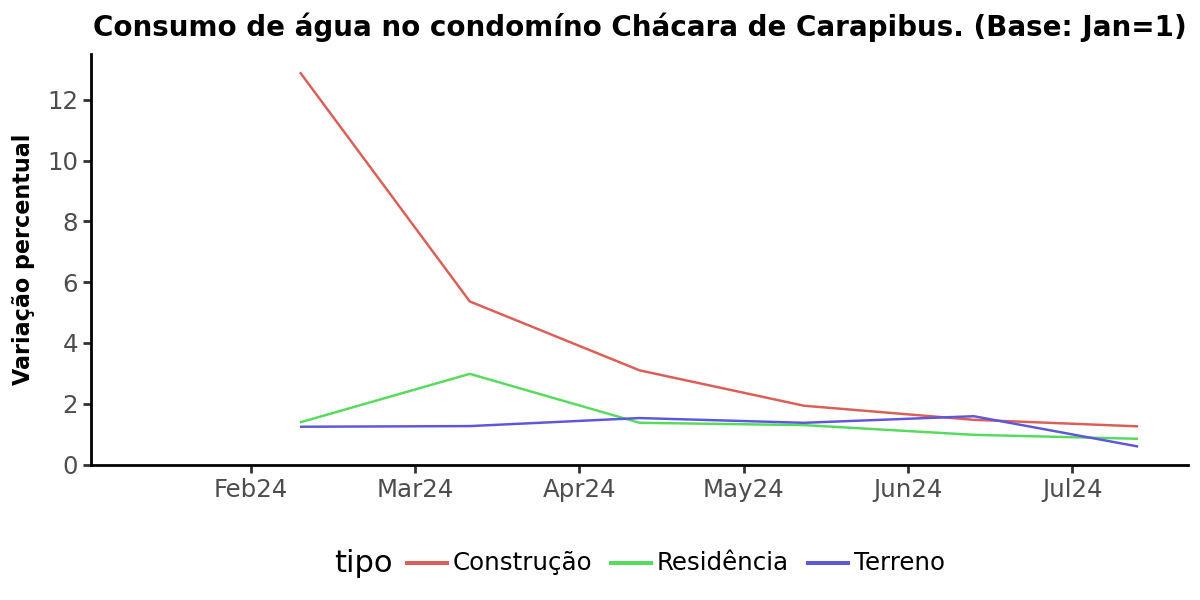

In [21]:
# Gráfico com variação mensal por tipo
(p9.ggplot(consumo_agrupado_mes,
           p9.aes(x='data',
                     y='var_pct',
                     fill='tipo',
                     colour='tipo',
                     )
             )
+ p9.geom_line()
+ p9.scale_x_date(date_breaks = "30 day", date_labels = "%b%y") 
+ p9.scale_y_continuous(breaks=range(0, 14, 2))
                       # n.breaks=5 # especificar o número de breaks) 
                       # breaks=[2, 5, 8], labels=['two', 'five', 'eight'] para customizar
+ p9.theme_classic()
+ p9.labs(x='',
          y='Variação percentual',
          title='Consumo de água no condomíno Chácara de Carapibus. (Base: Jan=1)',
          subtitle=''
          #caption=texto
         )
+ p9.theme(figure_size = (6, 3),
           legend_position = "bottom",
           plot_caption=p9.element_text(ha="left",
                                     margin={"t": 1,
                                             "units": "lines"}),
           plot_title=p9.element_text(size=10, face='bold'),
           axis_title_y=p9.element_text(size=8, face='bold')
          )
 
 
    )

In [22]:
consumo_agrupado = consumo_unidade.groupby(['data','tipo']).agg(
    quantidade   = ('tipo', 'size'),
    mim     = ('valor','min'),
    max     = ('valor','max'),
    media   = ('valor','mean'),
    mediana = ('valor','median'),
    total   = ('valor','sum'),
    desvio_padrao   = ('valor','std') 
).reset_index()

In [23]:
consumo_agrupado

,data,tipo,quantidade,mim,max,media,mediana,total,desvio_padrao
0,2024-01-30,Construção,14,0.267,1150.875,296.357857,67.2270,4149.0100,398.131091
1,2024-01-30,Residência,91,0.166,9832.363,1814.699462,1147.9150,165137.6510,1938.473755
2,2024-01-30,Terreno,233,0.080,9837.849,154.660940,0.2600,36035.9990,744.459310
3,2024-02-28,Construção,14,0.267,1168.292,334.617857,76.6090,4684.6500,441.524184
4,2024-02-28,Residência,91,0.000,9854.734,1839.834813,1195.3870,167424.9680,1969.802116
5,2024-02-28,Terreno,233,0.083,9837.849,156.584034,0.2590,36484.0800,746.545980
6,2024-03-30,Construção,14,0.267,1179.947,352.576286,104.0540,4936.0680,446.029187
7,2024-03-30,Residência,91,5.616,9887.859,1894.739451,1366.5110,172421.2900,1975.168102
8,2024-03-30,Terreno,233,0.089,9837.849,158.565515,0.2650,36945.7650,747.985719
9,2024-04-30,Construção,14,0.267,1184.028,363.503857,123.4930,5089.0540,445.377296


In [24]:
consumo_agrupado['mes'] = consumo_agrupado.data.dt.month

In [26]:
# Dez maiores consumo de água por Residência no período (Jul)
consumo_unidade[consumo_unidade['tipo']=='Residência'].groupby(['unidade', 'propietario'])['valor'].sum().sort_values(ascending=False).head(10)

unidade  propietario                             
L16 QR   PEDROSSIAN BERNARDO MEIRA                   69241.947
L04 QH   JOSÉ MÁRIO VASCONCELOS DE CASTRO SEGUNDO    67917.977
L17 QS   JOSENALDO ALVES DE OLIVEIRA                 47838.958
L07 QU   GABRIELA SOUZA DE ARAUJO ALBUQUERQUE        39301.811
L06 QF   SILVANA HENRIQUES DE MEDEIROS               36885.597
L06 QK   ANTONIO SPAGNUOLO                           35527.136
L09 QD   VERA LUCIA MOURA NOBREGA                    35310.457
L03 QH   GILVANILZA CARDOSO SOARES                   34973.621
L17 QO   MACIEL LOCACOES CONSTRUÇOES                 31439.190
L08 QE   JORDANA DE ALMEIDA NOGUEIRA J               30063.051
Name: valor, dtype: float64

In [27]:
# Dez maiores consumo de água por Residência no período (Jul)
consumo_unidade[(consumo_unidade['data']=='2024-07-30') & (consumo_unidade['tipo']=='Residência')].sort_values('valor',
                                                                                                               ascending=False).head(10)

,lote,quadra,unidade,propietario,valor,data,poco,tipo
2320,L16,QR,L16 QR,PEDROSSIAN BERNARDO MEIRA,9936.861,2024-07-30,NÃO,Residência
2163,L04,QH,L04 QH,JOSÉ MÁRIO VASCONCELOS DE CASTRO SEGUNDO,9896.485,2024-07-30,NÃO,Residência
2338,L17,QS,L17 QS,LILIA ALVES DE OLIVEIRA GUIMARAES,8535.582,2024-07-30,NÃO,Residência
2361,L07,QU,L07 QU,GABRIELA SOUZA DE ARAUJO ALBUQUERQUE,5640.647,2024-07-30,NÃO,Residência
2127,L06,QF,L06 QF,SILVANA HENRIQUES DE MEDEIROS,5502.367,2024-07-30,NÃO,Residência
2202,L06,QK,L06 QK,ANTONIO SPAGNUOLO,5169.167,2024-07-30,SIM,Residência
2092,L09,QD,L09 QD,VERA LUCIA MOURA NOBREGA,5129.067,2024-07-30,SIM,Residência
2162,L03,QH,L03 QH,GILVANILZA CARDOSO SOARES,5036.024,2024-07-30,SIM,Residência
2360,L06,QU,L06 QU,MARIA LUISA MARTINS DE SOUSA,4656.237,2024-07-30,NaN,Residência
2183,L05,QI,L05 QI,CHRISTIANE PEREIRA DE MESQUITA,4597.031,2024-07-30,NÃO,Residência


In [28]:
# Dez maiores consumo de água por Terreno no período (Jul)
consumo_unidade[(consumo_unidade['data']=='2024-07-30') & (consumo_unidade['tipo']=='Terreno')].sort_values('valor',
                                                                                                               ascending=False).head(10)

,lote,quadra,unidade,propietario,valor,data,poco,tipo
2208,L05,QL,L05 QL,EDNALVA MACIEL NEVES,9837.849,2024-07-30,NaN,Terreno
2220,L01,QM,L01 QM,MARINILSON RUFINO DA SILVA,3094.205,2024-07-30,NaN,Terreno
2337,L16,QS,L16 QS,JOSENALDO ALVES DE OLIVEIRA,2811.223,2024-07-30,NaN,Terreno
2351,L13,QT,L13 QT,MARCOS GELIELSON A. DA SILVA,2443.162,2024-07-30,NaN,Terreno
2138,L17,QF,L17 QF,LEONARDO VIDAL BATISTA,1703.090,2024-07-30,NaN,Terreno
2328,L07,QS,L07 QS,FERNANDO DE CASTRO SILVA,1492.461,2024-07-30,NaN,Terreno
2194,L16,QI,L16 QI,MATHEUS MOREIRA DA SILVA,1280.294,2024-07-30,NaN,Terreno
2113,L11,QE,L11 QE,CARLOS EDUARDO SOUTO DA SILVA,1221.166,2024-07-30,NaN,Terreno
2304,L17,QQ,L17 QQ,TATIANA C. VERÍSSIMO,1192.147,2024-07-30,NaN,Terreno
2305,L01,QR,L01 QR,LECIVALDO CAVALCANTE L. LIMA,1177.127,2024-07-30,NaN,Terreno


In [29]:
# Dez maiores consumo de água por Construção no período (Jul)
consumo_unidade[(consumo_unidade['data']=='2024-07-30') & (consumo_unidade['tipo']=='Construção')].sort_values('valor',
                                                                                                               ascending=False).head(10)

,lote,quadra,unidade,propietario,valor,data,poco,tipo
2119,L17,QE,L17 QE,ADILMA FIRMINO BATISTA NICOLAU,1184.818,2024-07-30,NaN,Construção
2314,L10,QR,L10 QR,PATRICIA CARMEN M F DE LIMA,1096.893,2024-07-30,NÃO,Construção
2150,L10,QG,L10 QG,LUIZ ANDRE DE MOURA SOUZA,912.196,2024-07-30,NÃO,Construção
2099,L16,QD,L16 QD,JANEIDE ARAUJO GAMA,899.000,2024-07-30,NÃO,Construção
2152,L12,QG,L12 QG,JOÃO PEDRO DE ALMEIDA SILVA,488.888,2024-07-30,NÃO,Construção
2061,L16,QB,L16 QB,RICARDO ZACARIAS PASSOS,204.236,2024-07-30,NÃO,Construção
2065,L01,QC,L01 QC,ANDRÉ LUIZ DE ALBUQUERQUE MARANHÃO,177.322,2024-07-30,NÃO,Construção
2111,L09,QE,L09 QE,IVONEIDE LUCENA PEREIRA,137.687,2024-07-30,NÃO,Construção
2250,L14,QN,L14 QN,VALÉRIA DE JESUS DOS SANTOS JOAQUIM,87.944,2024-07-30,NÃO,Construção
2117,L15,QE,L15 QE,VERA HELENA GAMBERINI,56.761,2024-07-30,NÃO,Construção


/home/gii-sti-01/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 6.5 x 4 in image.
/home/gii-sti-01/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ./figuras/grafico1_consumo_residencia.png


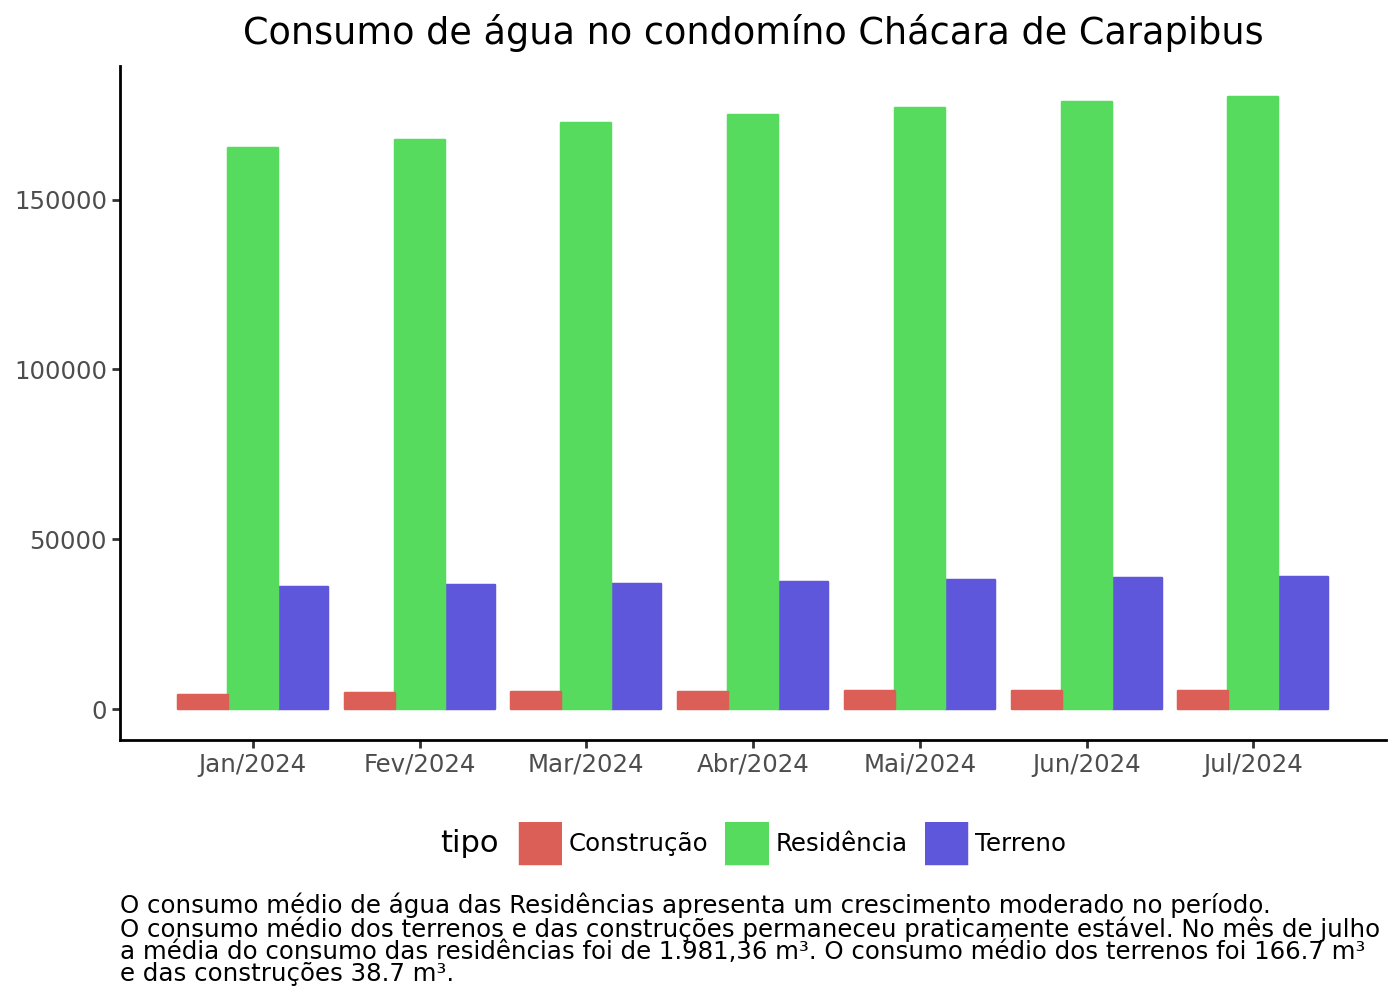

In [46]:
texto = '''O consumo médio de água das Residências apresenta um crescimento moderado no período.
O consumo médio dos terrenos e das construções permaneceu praticamente estável. No mês de julho
a média do consumo das residências foi de 1.981,36 m³. O consumo médio dos terrenos foi 166.7 m³
e das construções 38.7 m³.'''

    
grafico1 = (
    p9.ggplot(consumo_agrupado,
              p9.aes(x='mes',
                     y='total',
                     fill='tipo',
                     colour='tipo',
                     )
             )
+ p9.geom_col(position="dodge")
+ p9.scale_x_continuous(breaks = [1,2,3,4,5,6,7], labels=['Jan/2024',
                                                          'Fev/2024',
                                                          'Mar/2024',
                                                          'Abr/2024',
                                                          'Mai/2024',
                                                          'Jun/2024',
                                                          'Jul/2024'])
                 # limits=limits,
                  #date_labels = "%b%y") 
+ p9.theme_classic()
+ p9.labs(x='',
          y='',
          title='Consumo de água no condomíno Chácara de Carapibus',
          subtitle='',
          caption=texto
         )
+ p9.theme(figure_size = (7, 5),
           legend_position = "bottom",
           plot_caption=p9.element_text(ha="left",
                                     margin={"t": 1,
                                             "units": "lines"}))    
       )
grafico1.save(filename='./figuras/grafico1_consumo_residencia.png',
              format='png',
              path="",
              width=6.5,
              height=4,
              units="in",
              dpi=100,
              limitsize=True,
              verbose=True,
              )

grafico1

/home/gii-sti-01/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 6.5 x 4 in image.
/home/gii-sti-01/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ./figuras/grafico2_consumo_residencia.png


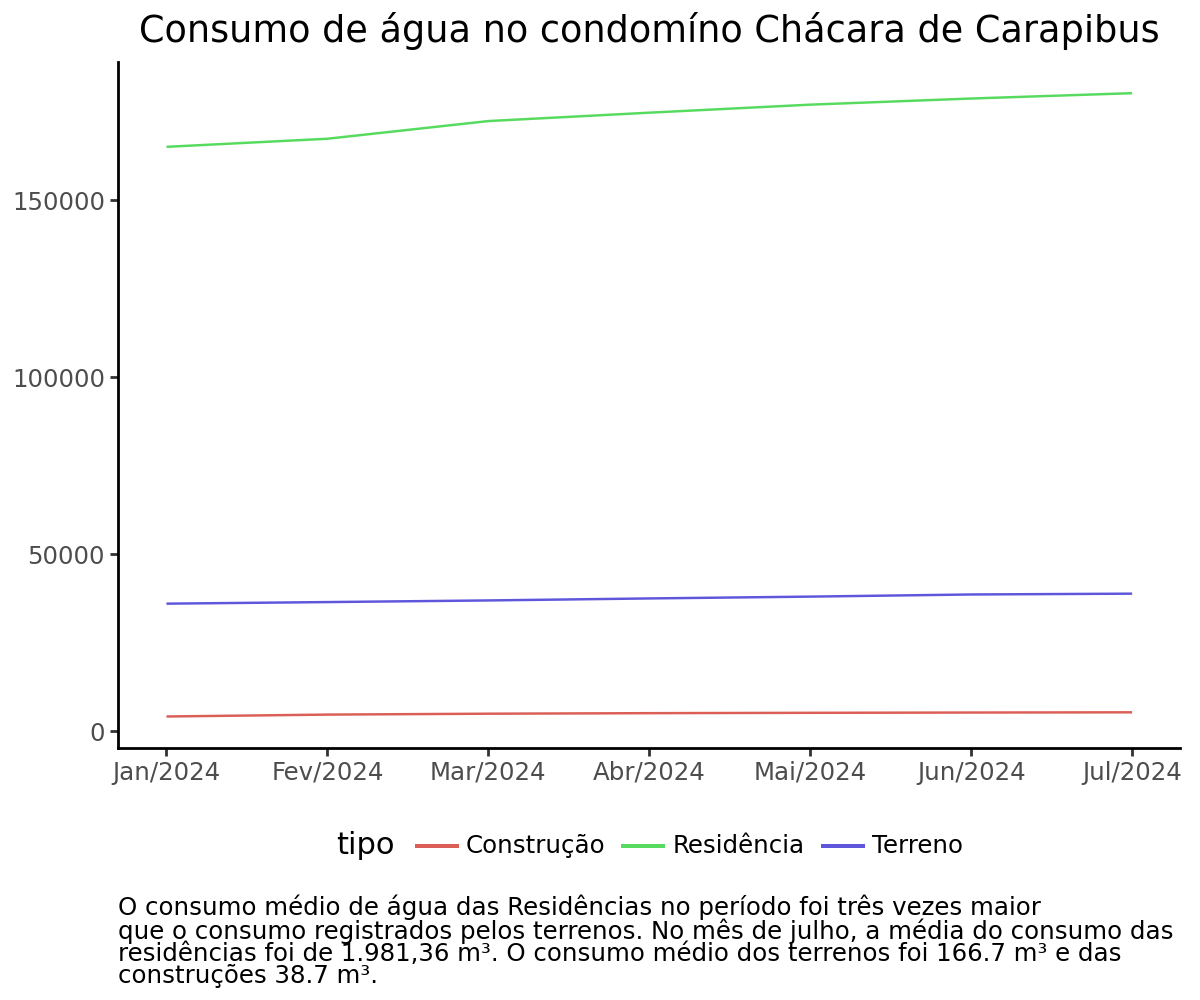

In [45]:
texto = '''O consumo médio de água das Residências no período foi três vezes maior
que o consumo registrados pelos terrenos. No mês de julho, a média do consumo das
residências foi de 1.981,36 m³. O consumo médio dos terrenos foi 166.7 m³ e das
construções 38.7 m³.'''

    
grafico2 = (
    p9.ggplot(consumo_agrupado,
              p9.aes(x='mes',
                     y='total',
                     fill='tipo',
                     colour='tipo',
                     )
             )
+ p9.geom_line()
+ p9.scale_x_continuous(breaks = [1,2,3,4,5,6,7], labels=['Jan/2024',
                                                          'Fev/2024',
                                                          'Mar/2024',
                                                          'Abr/2024',
                                                          'Mai/2024',
                                                          'Jun/2024',
                                                          'Jul/2024'])
                 # limits=limits,
                  #date_labels = "%b%y") 
+ p9.theme_classic()
+ p9.labs(x='',
          y='',
          title='Consumo de água no condomíno Chácara de Carapibus',
          subtitle='',
          caption=texto
         )
+ p9.theme(figure_size = (6, 5),
           legend_position = "bottom",
           plot_caption=p9.element_text(ha="left",
                                     margin={"t": 1,
                                             "units": "lines"}))    
       )
grafico1.save(filename='./figuras/grafico2_consumo_residencia.png',
              format='png',
              path="",
              width=6.5,
              height=4,
              units="in",
              dpi=100,
              limitsize=True,
              verbose=True,
              )

grafico2

/home/gii-sti-01/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/gii-sti-01/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ./figuras/box_plot_onsumo_residencia.png


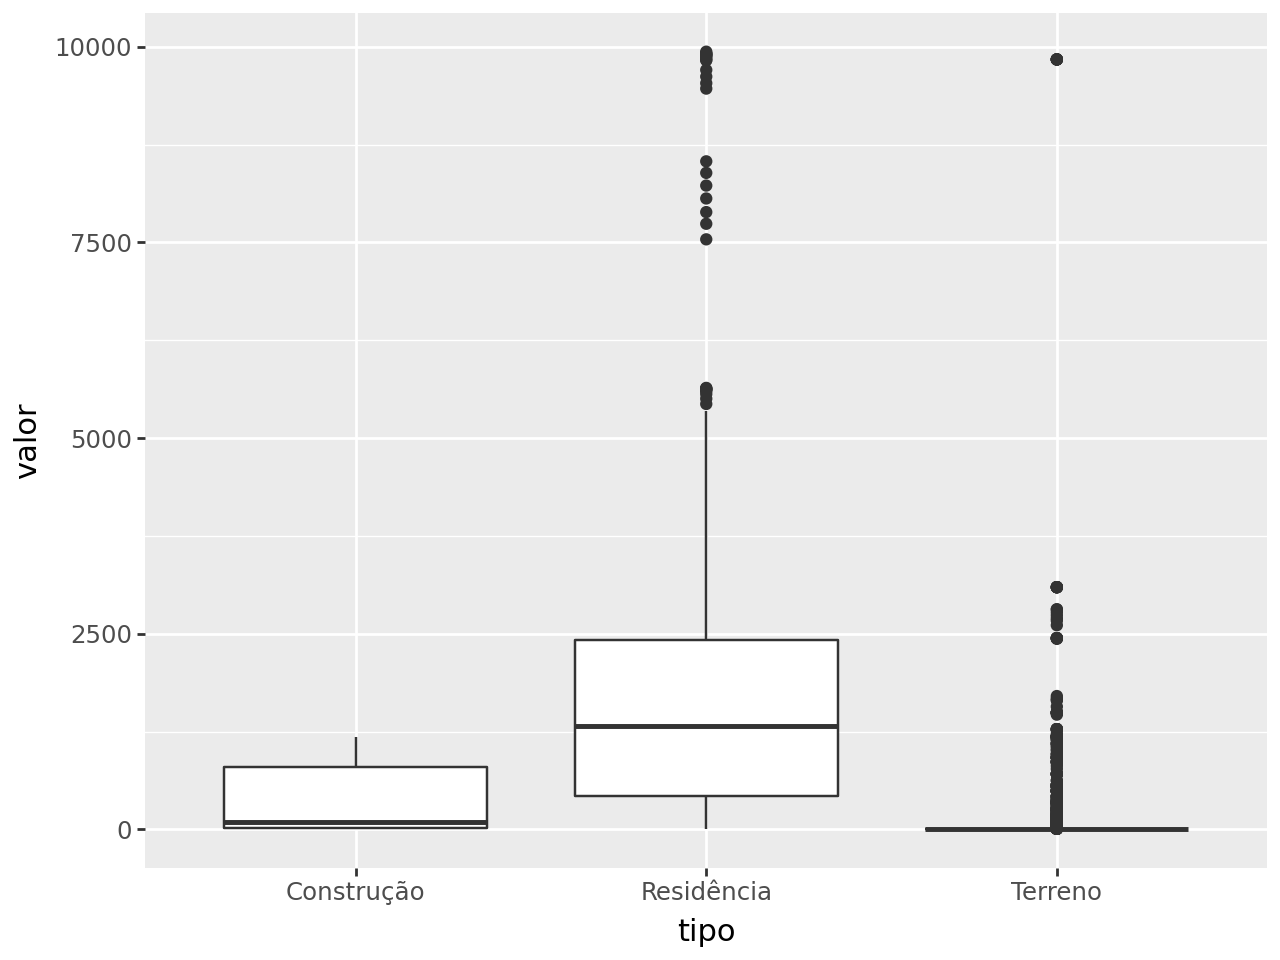

In [44]:
box_plot1 = (
p9.ggplot(consumo_unidade,
          p9.aes('tipo', 'valor'))
+ p9.geom_boxplot()
)
box_plot1.save(filename='./figuras/box_plot_onsumo_residencia.png',
              format='png',
              dpi=200)
box_plot1

In [33]:
# Dicionario De Para 
mes = {
    'Jan': '01',
    'Fev': '02',
    'Mar': '03',
    'Abr': '04',
    'Mai': '05',
    'Jun': '06',
    'Jul': '07',
    'Ago': '08',
    'Set': '09',
    'Out': '10',
    'Nov': '11',
    'Dez': '12'
}
mes2= {
   1:'Jan',
   2:'Fev',
   3:'Mar',
   4:'Abr',
   5:'Mai',
   6:'Jun',
   7:'Jul',
   8:'Ago',
   9:'Set',
   10:'Out',
   11:'Nov',
   12:'Dez'
}

In [34]:
consumo_agrupado_cp = consumo_agrupado.copy()

In [35]:
consumo_agrupado_cp

,data,tipo,quantidade,mim,max,media,mediana,total,desvio_padrao,mes
0,2024-01-30,Construção,14,0.267,1150.875,296.357857,67.2270,4149.0100,398.131091,1
1,2024-01-30,Residência,91,0.166,9832.363,1814.699462,1147.9150,165137.6510,1938.473755,1
2,2024-01-30,Terreno,233,0.080,9837.849,154.660940,0.2600,36035.9990,744.459310,1
3,2024-02-28,Construção,14,0.267,1168.292,334.617857,76.6090,4684.6500,441.524184,2
4,2024-02-28,Residência,91,0.000,9854.734,1839.834813,1195.3870,167424.9680,1969.802116,2
5,2024-02-28,Terreno,233,0.083,9837.849,156.584034,0.2590,36484.0800,746.545980,2
6,2024-03-30,Construção,14,0.267,1179.947,352.576286,104.0540,4936.0680,446.029187,3
7,2024-03-30,Residência,91,5.616,9887.859,1894.739451,1366.5110,172421.2900,1975.168102,3
8,2024-03-30,Terreno,233,0.089,9837.849,158.565515,0.2650,36945.7650,747.985719,3
9,2024-04-30,Construção,14,0.267,1184.028,363.503857,123.4930,5089.0540,445.377296,4


In [36]:
consumo_agrupado_cp['mes'] = consumo_agrupado_cp['data'].dt.month.map(mes2)

In [37]:
consumo_agrupado_cp

,data,tipo,quantidade,mim,max,media,mediana,total,desvio_padrao,mes
0,2024-01-30,Construção,14,0.267,1150.875,296.357857,67.2270,4149.0100,398.131091,Jan
1,2024-01-30,Residência,91,0.166,9832.363,1814.699462,1147.9150,165137.6510,1938.473755,Jan
2,2024-01-30,Terreno,233,0.080,9837.849,154.660940,0.2600,36035.9990,744.459310,Jan
3,2024-02-28,Construção,14,0.267,1168.292,334.617857,76.6090,4684.6500,441.524184,Fev
4,2024-02-28,Residência,91,0.000,9854.734,1839.834813,1195.3870,167424.9680,1969.802116,Fev
5,2024-02-28,Terreno,233,0.083,9837.849,156.584034,0.2590,36484.0800,746.545980,Fev
6,2024-03-30,Construção,14,0.267,1179.947,352.576286,104.0540,4936.0680,446.029187,Mar
7,2024-03-30,Residência,91,5.616,9887.859,1894.739451,1366.5110,172421.2900,1975.168102,Mar
8,2024-03-30,Terreno,233,0.089,9837.849,158.565515,0.2650,36945.7650,747.985719,Mar
9,2024-04-30,Construção,14,0.267,1184.028,363.503857,123.4930,5089.0540,445.377296,Abr


/home/gii-sti-01/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 6 x 4 in image.
/home/gii-sti-01/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ./figuras/grafico3_residencia_box


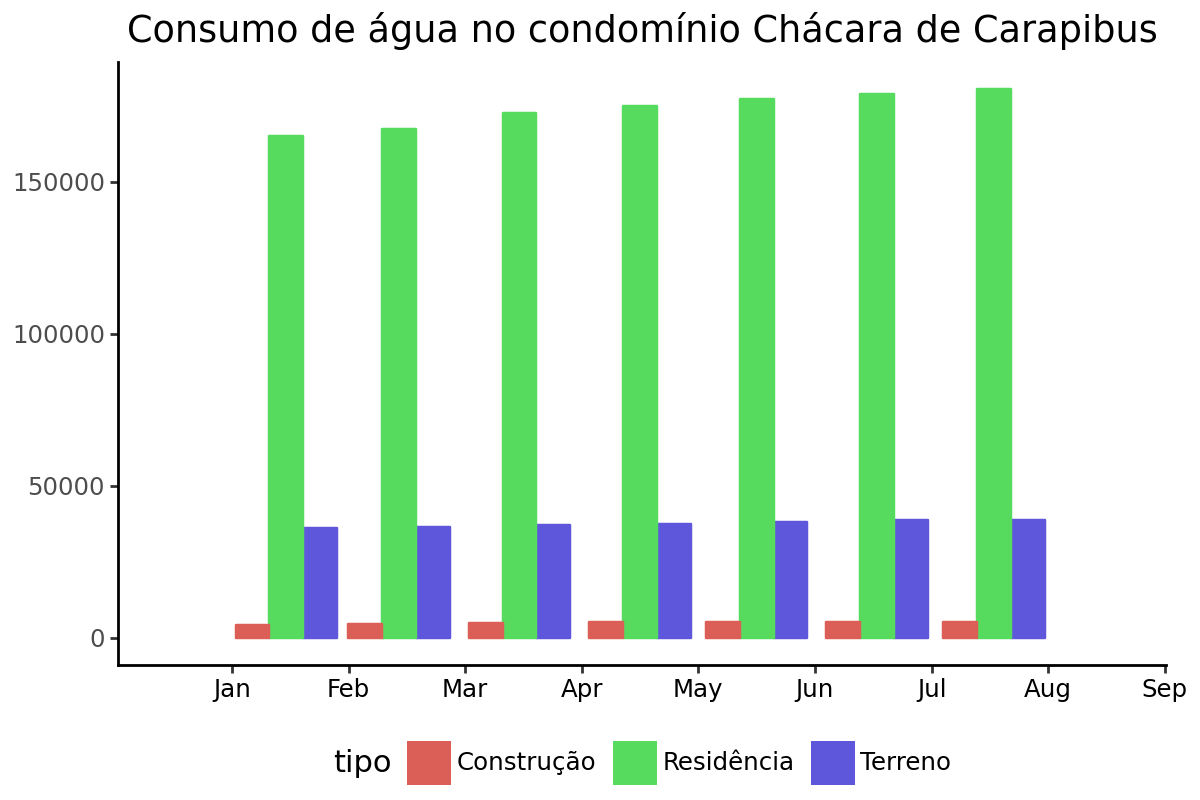

In [43]:
limits = ('2023-12-30', '2024-08-31')

grafico3 = (
    p9.ggplot(consumo_agrupado,
              p9.aes(x='data',
                     y='total',
                     fill='tipo',
                     colour='tipo')
             )
    + p9.scale_x_date(date_breaks="30 days",
                      limits=limits,
                      date_labels="%b")
    + p9.geom_col(position="dodge")
    + p9.theme_classic()
    + p9.labs(x='', y='', title='Consumo de água no condomínio Chácara de Carapibus')
    + p9.theme(axis_text_x=p9.element_text(color='black',
                                           ha='center'),
              figure_size = (6, 4),
              legend_position = "bottom")
)
grafico3.save(filename='./figuras/grafico3_residencia_box',
              format='png',
              dpi=200)
grafico3